In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import pandas as pd
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [4]:
import torch
from pipeline_sd3_controlnet_inpaint_custom import SD3_ControlNet_Custom_Inpainting_Pipeline
from custom_controlnet_sd3 import SD3ControlNetModel, SD3MultiControlNetModel

In [5]:
model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
controlnet_inpaint = SD3ControlNetModel.from_pretrained(
    "alimama-creative/SD3-Controlnet-Inpainting", 
    use_safetensors=True, extra_conditioning_channels=1
)
controlnet_pose = SD3ControlNetModel.from_pretrained(
    "InstantX/SD3-Controlnet-Pose"
)

controlnet = SD3MultiControlNetModel(
    [
        controlnet_inpaint, 
        controlnet_pose
    ]
)

In [ ]:
pipe = SD3_ControlNet_Custom_Inpainting_Pipeline.from_pretrained(
    model_id,
    controlnet=controlnet,)
pipe.to(torch.float16)
pipe.enable_model_cpu_offload(gpu_id=0)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

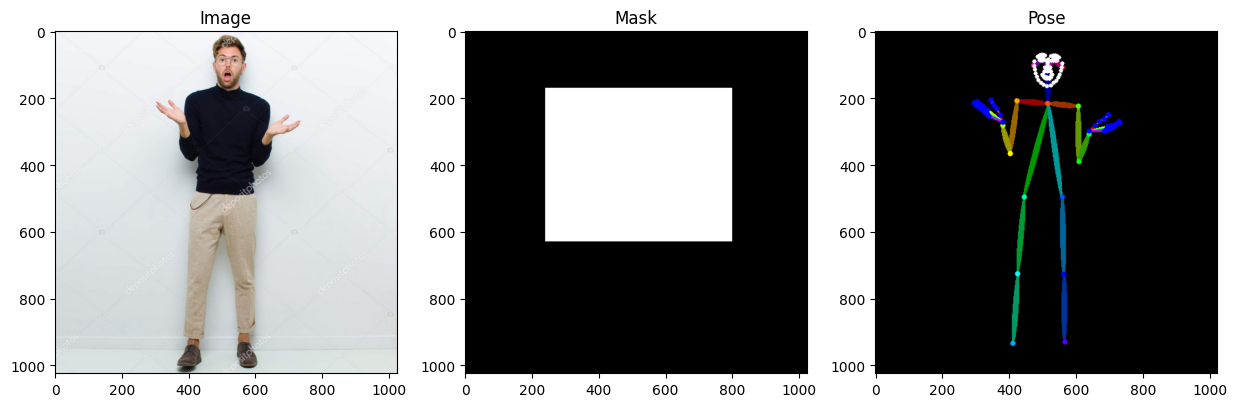

In [ ]:
image = Image.open("assets/sample_image.png")
mask = Image.open("assets/sample_mask.png")
pose = Image.open("assets/sample_pose_1.png")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask, cmap = "gray")
ax[1].set_title("Mask")
ax[2].imshow(pose)
ax[2].set_title("Pose")
plt.show()



In [ ]:
width = 1024
height = 1024
generator = torch.Generator().manual_seed(0)


control_images = [image, pose]
# set to None if the control != inpainting
control_masks = [mask, None]

assert len(control_images) == len(control_masks), "Number of control images and masks should be the same"


prompt = "dslr photo of a man in a striped black and red turtleneck, beige cropped pants, and brown shoes, standing against a white background with a surprised/confused expression"
n_prompt = "disfigured, cartoon, painting, doll, blurry, grainy, black and white, broken, cross-eyed, undead, photoshopped, overexposed, underexposed, rash, sunburn, mutated, alien, unthinking, unfeeling, unrealistic, cramped, flexing, soft lens, hard light, wobbly iris, square iris, flat iris, edge of iris following, surreal, surrealist, fiction, Wax sculpture, caricature, frame, fish, Neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie"

## ControlNets disabled 

this is classic text to image

Token indices sequence length is longer than the specified maximum sequence length for this model (117 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']
Token indices sequence length is longer than the specified maximum sequence length for this model (117 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']


  0%|          | 0/28 [00:00<?, ?it/s]

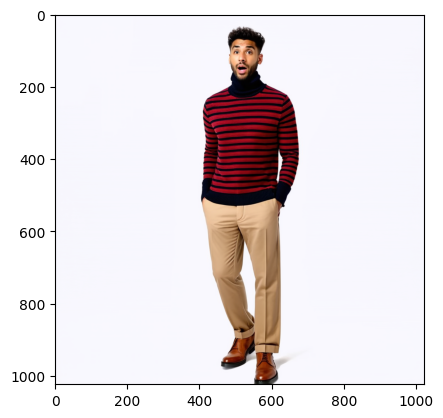

In [9]:
with torch.no_grad():
    res_image_0 = pipe(
        negative_prompt=n_prompt,
        prompt=prompt,
        height=height,
        width=width,
        control_image=control_images,
        control_mask=control_masks,
        num_inference_steps=28,
        generator=generator,
        controlnet_conditioning_scale=[0.0, 0.0],
        guidance_scale=7,
    ).images[0]

plt.imshow(res_image_0)


## Only Inpainting ControlNet enabled

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']


  0%|          | 0/28 [00:00<?, ?it/s]

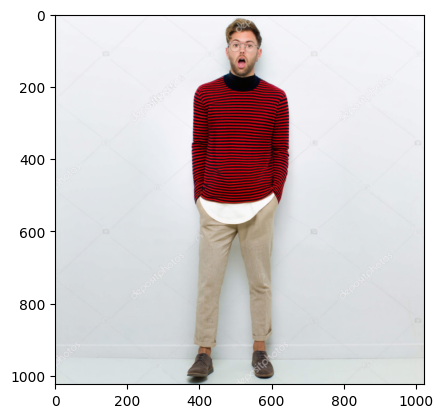

In [10]:
with torch.no_grad():
    res_image_1 = pipe(
        negative_prompt=n_prompt,
        prompt=prompt,
        height=height,
        width=width,
        control_image=control_images,
        control_mask=control_masks,
        num_inference_steps=28,
        generator=generator,
        controlnet_conditioning_scale=[1.0, 0.0],
        guidance_scale=7,
    ).images[0]

plt.imshow(res_image_1)


## Only Pose ControlNet enabled

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']


  0%|          | 0/28 [00:00<?, ?it/s]

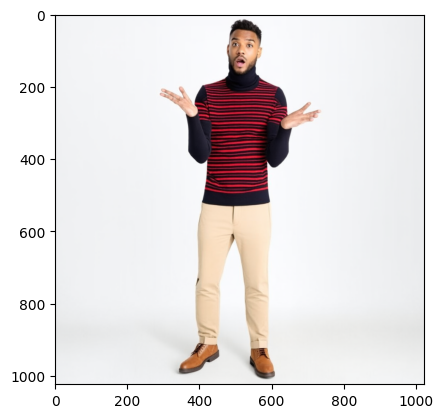

In [11]:
with torch.no_grad():
    res_image_2 = pipe(
        negative_prompt=n_prompt,
        prompt=prompt,
        height=height,
        width=width,
        control_image=control_images,
        control_mask=control_masks,
        num_inference_steps=28,
        generator=generator,
        controlnet_conditioning_scale=[0.0, 1.0],
        guidance_scale=7,
    ).images[0]

plt.imshow(res_image_2)


## MultiControlNet: Pose + Inpainting

In [13]:
with torch.no_grad():
    res_image_3 = pipe(
        negative_prompt=n_prompt,
        prompt=prompt,
        height=height,
        width=width,
        control_image=control_images,
        control_mask=control_masks,
        num_inference_steps=28,
        generator=generator,
        controlnet_conditioning_scale=[1.0, 1.0],
        guidance_scale=7,
    ).images[0]

plt.imshow(res_image_3)


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edge of iris following, surreal, surrealist, fiction, wax sculpture, caricature, frame, fish, neanderthal, reptile, rings, jewelry, cataracts, dumb eyes, creepy, zombie']


AssertionError: 

In [ ]:
images = [res_image_0, res_image_1, res_image_2, res_image_3]

for i, img in enumerate(images):
    
    # Save the image
    img.save(f"assets/res_{i}.png")